# SD-HOC Implementation

## Introduction

The SD-HOC algorithm is a predictive model designed to estimate the number of people in a room using carbon dioxide (CO2) measurements. Human occupancy counting is a valuable task in various domains, such as building automation, energy management, and indoor air quality control. By leveraging the relationship between CO2 concentration and human presence, the SD-HOC algorithm offers a non-intrusive and cost-effective solution for occupancy estimation.

## Visualizing the data

### People Count RGB

We start by importing the necessary libraries and loading the data.

We were using JSON files to store the data.We prefered JSON files because they are easy to read and write, lightweight, and can be parsed easily. We used the JSON library to load the data and convert it to a pandas dataframe.

In [23]:
import sys
import os
import plotly.express as px


from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


head, _ = os.path.split(sys.path[0])
sys.path[0] = head

import src.utils as utils

# load the data
files =[ '../data/visualisation/V6AD_20210211.json',
         '../data/visualisation/V6AD_20210212.json',
         '../data/visualisation/V6AD_20210213.json',
         '../data/visualisation/V6AD_20210214.json',
         '../data/visualisation/V6AD_20210215.json',
         '../data/visualisation/V6AD_20210216.json']


# # create the dataframes
df = utils.create_df_(files)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14685 entries, 0 to 14684
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   deviceID            4209 non-null   object 
 1   time                14685 non-null  int64  
 2   peoplecount_ir_est  4209 non-null   float64
 3   ir_raw_data_array   4209 non-null   object 
 4   occupancy           14685 non-null  int64  
 5   peoplecount_rgb     14685 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 688.5+ KB


As we can see below, the data is stored in a pandas dataframe. The dataframe contains 5 columns: 
- `deviceID` - the ID of the device that collected the data
- `time` - the timestamp of the measurement
- `peoplecount_ir_est` - the number of people in the room estimated by the IR sensor
- `ir_raw_data_array` - the raw data collected by the IR sensor
- `occupancy` - whether the room is occupied or not
- `peoplecount_rgb` - the number of people in the room estimated by the RGB sensor

 > **NB:** The peoplecount_rgb column was supervised by the user. The user had to manually input the number of people in the room at the time of the measurement. This was done to have a ground truth to compare the SD-HOC algorithm's predictions to.


In [25]:
df.head()

deviceID           time  peoplecount_ir_est  \
0               None  1612998020125                 NaN   
1               None  1612998074256                 NaN   
2  MS-IPac67b205b3b7  1612998084000                 0.0   
3               None  1612998136051                 NaN   
4               None  1612998197341                 NaN   

                                   ir_raw_data_array  occupancy  \
0                                               None          0   
1                                               None          0   
2  [994, 982, 991, 965, 931, 917, 886, 877, 912, ...          0   
3                                               None          0   
4                                               None          0   

   peoplecount_rgb  
0               -7  
1                0  
2                0  
3                0  
4                0

A quick overview of the data shows that the data is not clean. The NaN values in deviceID mean that this was only the mesure of the RGB sensor.   
Also some "-7" values in the peoplecount_rgb column are due the server problems.

We can also see that the time is the number of seconds since the epoch. We will convert it to a datetime object for easier manipulation.

We are gonna store the deviceID in a variable because we might need it later.   
We will transform the time column to a datetime object and only keep the columns we need.

In [26]:
# keep only the columns we need
device_id = df['deviceID'].unique()[1]
print(device_id)

# transform epoch time to datetime
df.loc[:, 'time'] = df['time'].apply(utils.epoch_to_datetime)

df = df[['time', 'peoplecount_rgb']]

# delete all rows with peoplecount_rgb = -7
df = df[df['peoplecount_rgb'] != -7]

MS-IPac67b205b3b7


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14185 entries, 1 to 14684
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             14185 non-null  datetime64[ns]
 1   peoplecount_rgb  14185 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 332.5 KB


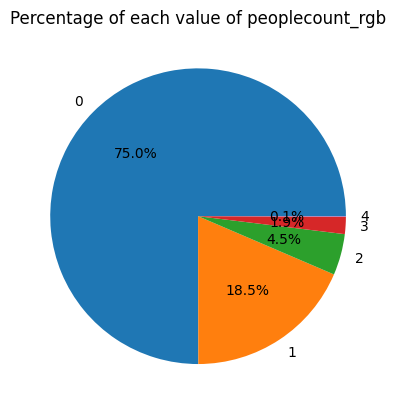

In [28]:
# Calculate value counts for the peoplecount_rgb column
value_counts = df['peoplecount_rgb'].value_counts()
fig = px.pie(values=value_counts.values, names=value_counts.index, title='Percentage of each value of peoplecount_rgb')
fig.show()
# use matplotlib to plot the same pie chart (for github)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%') 
ax.set_title('Percentage of each value of peoplecount_rgb')
plt.show()



As we can see, there are a lot of 0 values in the peoplecount_rgb column. It's okay because these are time series data.

### Time series plot

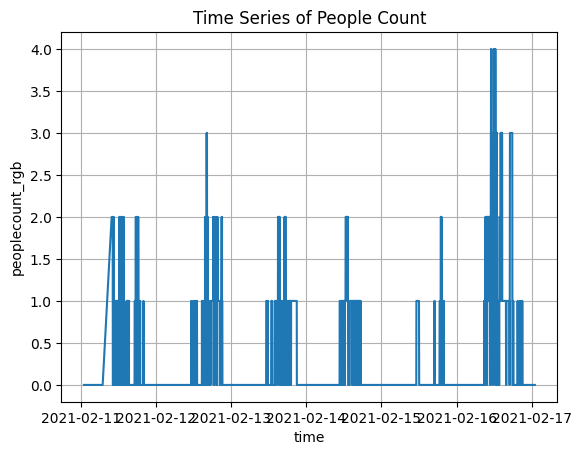

In [29]:
# plot time series of people count
utils.plot_time_series(df,'peoplecount_rgb','People Count',matplotlib = False)
utils.plot_time_series(df,'peoplecount_rgb','People Count',matplotlib = True)

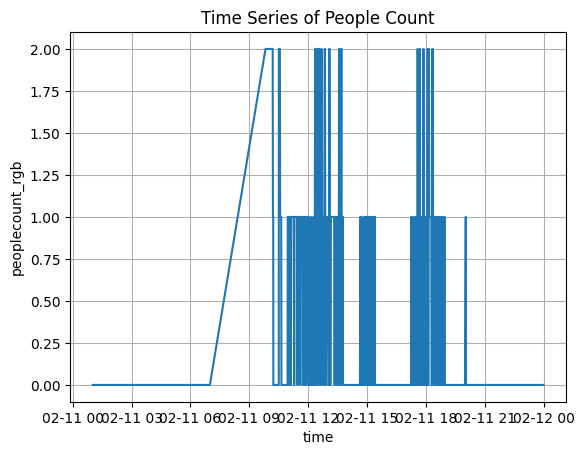

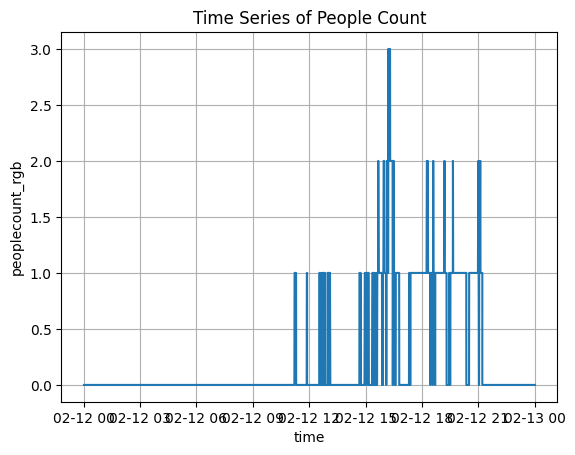

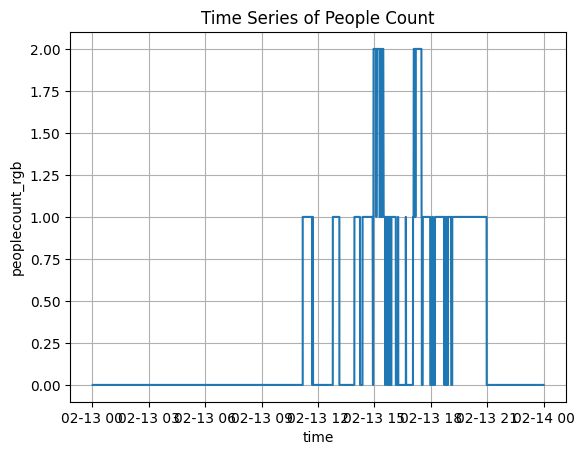

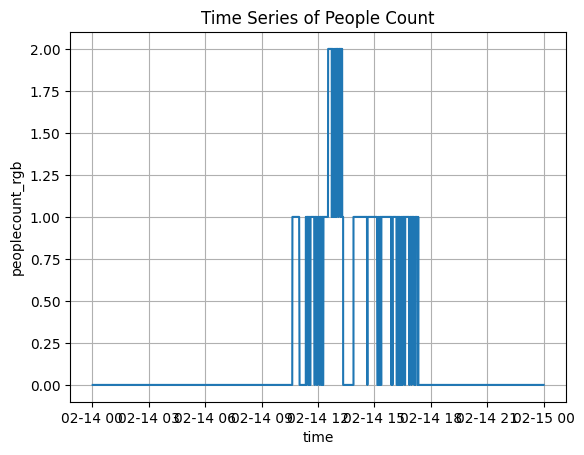

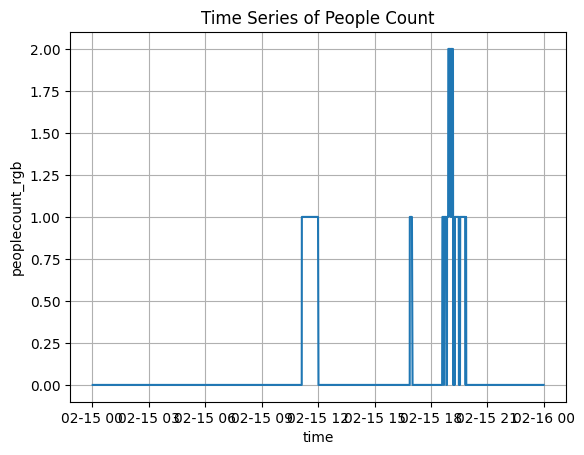

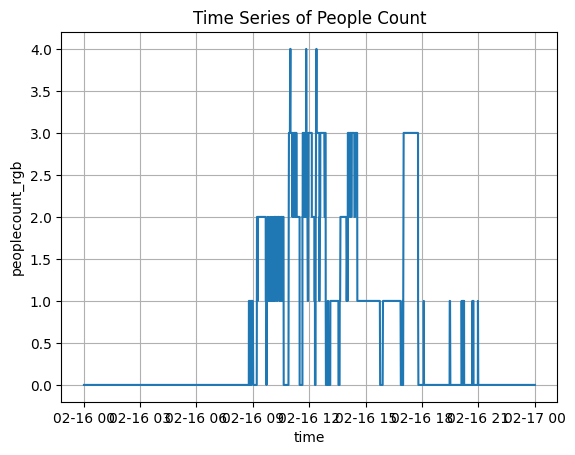

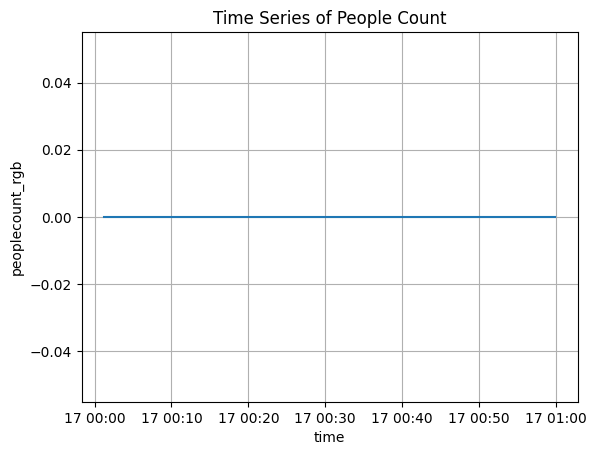

In [30]:
# plot time series of people count for each day
utils.plot_time_series_dbd(df,'peoplecount_rgb','People Count',matplotlib = False)
utils.plot_time_series_dbd(df,'peoplecount_rgb','People Count',matplotlib = True)

### CO2

We again start by importing the necessary libraries and loading the data.  
Now the data is stored in a csv file. We will use the pandas library to load the data and convert it to a pandas dataframe.

In [31]:
import pandas as pd

df_co2 = pd.read_csv(
    '../data/VTEC-Device_MS-IPac67b205b3df_2021-02-11_00_00_00-2021-02-16_23_59_59.csv', sep=';')

In [32]:
df_co2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51153 entries, 0 to 51152
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   timestamp                   51153 non-null  object 
 1   lightintensity              4993 non-null   float64
 2   tvoc                        13687 non-null  float64
 3   noise                       13083 non-null  object 
 4   humidity                    11 non-null     float64
 5   temperature                 5336 non-null   object 
 6   occupancy                   2582 non-null   float64
 7   co2-ndir                    5531 non-null   float64
 8   pm2.5                       581 non-null    float64
 9   pm10                        1086 non-null   float64
 10  peoplecount                 4244 non-null   float64
 11  deviceID                    51153 non-null  object 
 12  EpochTime/UnixTime ( UTC )  51153 non-null  float64
dtypes: float64(9), object(4)
memory

Again as we can see below, the data is stored in a pandas dataframe. The dataframe contains 13 columns:  
- `timestamp` - the timestamp of the measurement
- `lightintensity` - the light intensity in the room
- `tvoc` - the total volatile organic compounds in the room
- `noise` - the noise in the room
- `humidity` - the humidity in the room
- `temperature` - the temperature in the room
- `occupancy` - whether the room is occupied or not
- `co2-ndir` - the CO2 concentration in the room
- `pm2.5` - the PM2.5 concentration in the room
- `pm10` - the PM10 concentration in the room
- `peoplecount` - the number of people in the room estimated by the IR sensor
- `deviceID` - the ID of the device that collected the data
- `EpochTime/UnixTime` - the timestamp of the measurement in seconds since the epoch

In [33]:
df_co2.head()

timestamp  lightintensity  tvoc   noise  humidity temperature  \
0  11-2-2021 00:00:02             NaN   NaN     NaN       NaN       10,55   
1  11-2-2021 00:00:26             NaN   NaN  40,921       NaN         NaN   
2  11-2-2021 00:01:09             NaN   NaN   40,81       NaN         NaN   
3  11-2-2021 00:01:10             NaN   NaN     NaN       NaN         NaN   
4  11-2-2021 00:01:35             NaN   NaN  41,972       NaN         NaN   

   occupancy  co2-ndir  pm2.5  pm10  peoplecount           deviceID  \
0        NaN       NaN    NaN   NaN          NaN  MS-IPac67b205b3df   
1        NaN       NaN    NaN   NaN          NaN  MS-IPac67b205b3df   
2        NaN       NaN    NaN   NaN          NaN  MS-IPac67b205b3df   
3        NaN       NaN    NaN   NaN          0.0  MS-IPac67b205b3df   
4        NaN       NaN    NaN   NaN          NaN  MS-IPac67b205b3df   

   EpochTime/UnixTime ( UTC )  
0                1.612998e+09  
1                1.612998e+09  
2                1.612998e+09  
3                1.612998e+09  
4                1.612998e+09

After a quick overview of the data, we notice that we only need the `timestamp` and `co2-ndir`, but as we did for the RGB data, we will work with the EpochTime/UnixTime column, that we will transform to a datetime object. 

In [34]:
# Multiply the EpochTime/UnixTime column to get epoch time in milliseconds and make it an integer
df_co2['EpochTime/UnixTime ( UTC )'] = df_co2['EpochTime/UnixTime ( UTC )'].apply(lambda x: int(x * 1000)) 

# Transform epoch time to datetime, let the function know that the time is in GMT+1
df_co2['timestamp'] = df_co2['EpochTime/UnixTime ( UTC )'].apply(utils.epoch_to_datetime, h_add=1)

# Keep only 'timestamp' and non-null 'co2-ndir' columns
df_co2 = df_co2[['timestamp', 'co2-ndir']].dropna()

We used `h_add = 1` to be in coordination with the RGB data and also the visualisation on the data dashboard.  
We will also only keep the columns we need.  

Here we can see that the data is clean. There are no NaN values and the data is complete.

In [35]:
df_co2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531 entries, 14 to 51148
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  5531 non-null   datetime64[ns]
 1   co2-ndir   5531 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 129.6 KB


We will still rename the columns to make it easier to work with.

In [36]:
# rename columns
df_co2.columns = ['time', 'co2']

We first make sure to delete all the data that is not in the same time frame as the RGB data.  
And here we can see that the data is clean. There are no NaN values and the data is complete.

In [37]:
# delete all data after 2021-02-16 23:59:59
df_co2 = df_co2[df_co2['time'] < '2021-02-17']
df_co2.head()

time    co2
14  2021-02-11 00:03:48.825  454.0
22  2021-02-11 00:04:34.569  462.0
35  2021-02-11 00:08:00.235  446.0
77  2021-02-11 00:18:49.148  453.0
135 2021-02-11 00:33:49.410  458.0

Here is a nice plot of the CO2 concentration in the room over time.

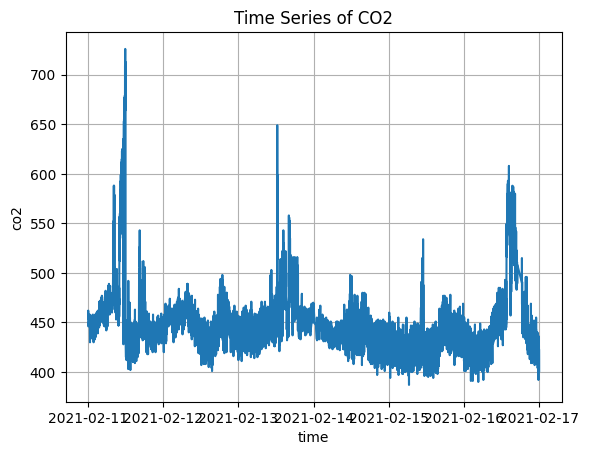

In [38]:
utils.plot_time_series(df_co2,'co2','CO2',matplotlib = False)
utils.plot_time_series(df_co2,'co2','CO2',matplotlib = True) # for github

Now what we need to do is to resample the data to have the same time frame as the RGB data.  
We will use `Nearest Neighbors Matching` to do that. It consists of finding the closest value in the CO2 data for each value in the RGB data.

In [39]:
# Sort the CO2 dataframe by the timestamp
df_co2 = df_co2.sort_values('time')

# Nearest Neighbor Matching
df_matched = pd.merge_asof(df, df_co2, on='time', direction='nearest')

# Fuzzy Matching
time_window = pd.Timedelta(minutes=1)  # Define the time window (adjust as needed)
df_matched = pd.merge_asof(df, df_co2, on='time', tolerance=time_window)

And here is the final data that we will use for the SD-HOC algorithm. We will not forget to delete the unnecessary columns, rename the columns to make it easier to work with and delete the NaN values. 

In [40]:
df_matched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14185 entries, 0 to 14184
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             14185 non-null  datetime64[ns]
 1   peoplecount_rgb  14185 non-null  int64         
 2   date             14185 non-null  object        
 3   co2              6573 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 554.1+ KB


In [41]:
# only keep the columns we need
df_matched = df_matched[['time', 'peoplecount_rgb', 'co2']]
df_matched.dropna(inplace=True)
df_matched.head()

time  peoplecount_rgb    co2
5  2021-02-11 01:04:15.644                0  438.0
9  2021-02-11 01:06:15.321                0  434.0
10 2021-02-11 01:07:16.369                0  454.0
11 2021-02-11 01:07:30.000                0  454.0
13 2021-02-11 01:09:15.836                0  435.0

Lets have a look at the final data.

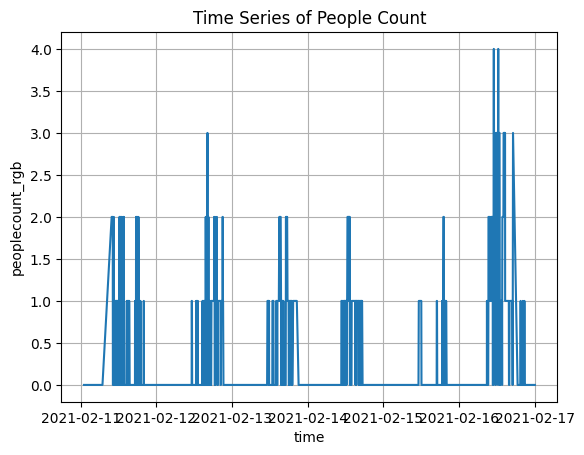

In [42]:
utils.plot_time_series(df_matched,'peoplecount_rgb','People Count',matplotlib = False)
utils.plot_time_series(df_matched, 'peoplecount_rgb','People Count',matplotlib = True) # for github

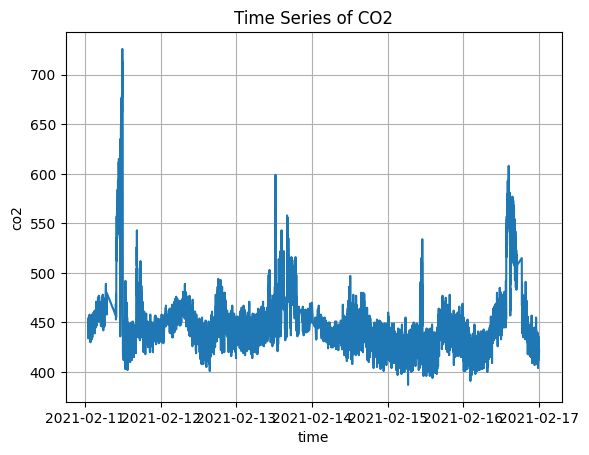

In [43]:
utils.plot_time_series(df_matched,'co2','CO2',matplotlib = False)
utils.plot_time_series(df_matched, 'co2','CO2',matplotlib = True) # for github

In [44]:
# lets save the data 
df_matched.to_csv('../data/final_df.csv', index=False)